In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import pennylane as qml


In [27]:
# Load dataset
df = pd.read_csv("final_combined_mutation_dataset.csv")

# Convert stringified lists into actual lists
df["Encoded_Sequence"] = df["Encoded_Sequence"].apply(eval)

# Truncate or pad to fixed length
SEQ_LEN = 20
def process_seq(seq):
    if len(seq) >= SEQ_LEN:
        return seq[:SEQ_LEN]
    else:
        return seq + [0] * (SEQ_LEN - len(seq))

df["Processed_Seq"] = df["Encoded_Sequence"].apply(process_seq)

# Prepare features and labels
X = np.array(df["Processed_Seq"].tolist())
y = df["Mutation_Label"].values

# Normalize sequence values to [-π, π]
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [28]:
n_qubits = SEQ_LEN
dev = qml.device("default.qubit", wires=n_qubits)

def feature_map(x):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RY(x[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i + 1])

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    feature_map(x1)
    qml.adjoint(feature_map)(x2)
    return qml.probs(wires=range(n_qubits))  # return full probability vector


In [29]:
from sklearn.preprocessing import StandardScaler

# Feature scaling (important for SVM/QSVM)
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_scaled = scaler.fit_transform(X)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [31]:
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # make sure it's installed or remove tqdm for pure Python

def compute_kernel_quantum(x1, x2):
    return kernel_circuit(x1, x2)[0]  # get probability of measuring all-zeros state

def compute_kernel_matrix(X1, X2):
    n1 = len(X1)
    n2 = len(X2)
    K = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = compute_kernel_quantum(X1[i], X2[j])
    return K


# Combine full dataset before sampling
X_all = np.concatenate((X_train, X_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

# Reduce sample size
# Use 50 samples instead of just 10
X_limited = X_all[:1000]
y_limited = y_all[:1000]

# Re-split the smaller set
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_limited, y_limited, test_size=0.2, random_state=42, stratify=y_limited
)

# Optimized kernel matrix computation
def compute_kernel_matrix(X1, X2, symmetric=False):
    n1 = len(X1)
    n2 = len(X2)
    K = np.zeros((n1, n2))
    
    for i in tqdm(range(n1), desc="Computing kernel rows"):
        for j in range(i if symmetric else 0, n2):
            k_val = compute_kernel([X1[i]], [X2[j]])[0][0]
            K[i, j] = k_val
            if symmetric:
                K[j, i] = k_val  # use symmetry

    return K

print("🔄 Computing quantum kernel matrices on 10 samples...")

K_train = compute_kernel_matrix(X_train_small, X_train_small)
K_test = compute_kernel_matrix(X_test_small, X_train_small)



🔄 Computing quantum kernel matrices on 10 samples...


Computing kernel rows: 100%|██████████| 200/200 [00:00<00:00, 213.35it/s]


              precision    recall  f1-score   support

           0       0.48      0.51      0.50       101
           1       0.46      0.42      0.44        99

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.47      0.47      0.47       200



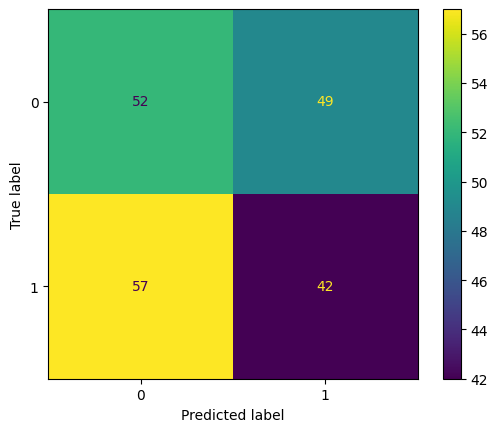

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

svc = SVC(kernel='precomputed', C=1)
svc.fit(K_train, y_train_small)

y_pred = svc.predict(K_test)

print(classification_report(y_test_small, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test_small, y_pred)


In [33]:
y_train_small = y_train_small[:K_train.shape[0]]



In [34]:
df.columns = df.columns.str.strip()  # removes leading/trailing spaces


In [35]:
from sklearn.svm import SVC

# Define classifier with regularization and better generalization
clf = SVC(kernel='precomputed', C=10, class_weight='balanced')

# Fit the classifier on the training kernel matrix
clf.fit(K_train, y_train_small)

# Calculate training and testing accuracy
train_acc = clf.score(K_train, y_train_small)
test_acc = clf.score(K_test, y_test_small)

# Print accuracy results
print(f"✅ QSVM Training Accuracy: {train_acc * 100:.2f}%")
print(f"✅ QSVM Test Accuracy: {test_acc * 100:.2f}%")


✅ QSVM Training Accuracy: 58.00%
✅ QSVM Test Accuracy: 44.00%


In [36]:
from scipy.special import expit  # Sigmoid function

# Get decision function scores
y_scores = clf.decision_function(K_test)

# Convert to percentage-like probabilities using sigmoid
y_percent = expit(y_scores) * 100  # Scale to 0-100%

# Create DataFrame for comparison
results_df = pd.DataFrame({
    "True_Label": y_test_small,
    "Predicted_Label": (y_percent >= 50).astype(int),
    "Prediction_Percent": y_percent
})

# Save to CSV
results_df.to_csv("qsvm_mutation_predictions.csv", index=False)
print("📁 Saved predictions with percentages to qsvm_mutation_predictions.csv")


📁 Saved predictions with percentages to qsvm_mutation_predictions.csv


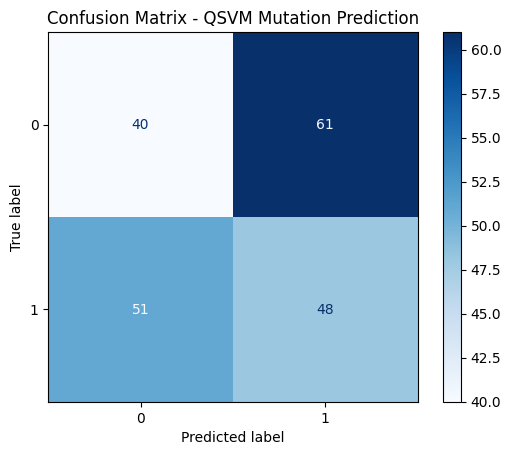

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(results_df["True_Label"], results_df["Predicted_Label"])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - QSVM Mutation Prediction")
plt.grid(False)
plt.show()


Sample 1: Predicted Mutation Probability: 50.00%
Sample 2: Predicted Mutation Probability: 51.95%
Sample 3: Predicted Mutation Probability: 50.69%
Sample 4: Predicted Mutation Probability: 46.62%
Sample 5: Predicted Mutation Probability: 45.59%
Sample 6: Predicted Mutation Probability: 51.30%
Sample 7: Predicted Mutation Probability: 48.41%
Sample 8: Predicted Mutation Probability: 46.59%
Sample 9: Predicted Mutation Probability: 48.33%
Sample 10: Predicted Mutation Probability: 46.26%
Sample 11: Predicted Mutation Probability: 49.16%
Sample 12: Predicted Mutation Probability: 47.77%
Sample 13: Predicted Mutation Probability: 48.73%
Sample 14: Predicted Mutation Probability: 49.41%
Sample 15: Predicted Mutation Probability: 51.82%
Sample 16: Predicted Mutation Probability: 48.60%
Sample 17: Predicted Mutation Probability: 48.50%
Sample 18: Predicted Mutation Probability: 49.33%
Sample 19: Predicted Mutation Probability: 50.00%
Sample 20: Predicted Mutation Probability: 50.00%
Sample 21

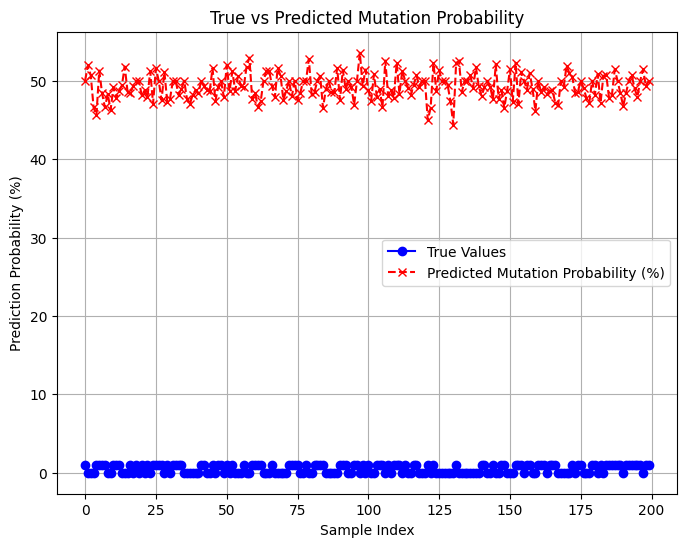

In [38]:
import numpy as np
import matplotlib.pyplot as plt  # Import for plotting

# Assuming you already have your kernel matrices computed: K_train, K_test, and y_test_small

# Train a classifier using kernel trick (SVM with a custom kernel)
from sklearn.svm import SVC  # For example, using SVM classifier

# Train SVM model using precomputed kernel with probability estimation
svm_clf = SVC(kernel='precomputed', probability=True)
svm_clf.fit(K_train, y_train_small)

# Predict probabilities on the test set using the kernel matrix
y_pred_proba = svm_clf.predict_proba(K_test)

# The probabilities are returned for each class; we want the probability for class 1 (mutation occurring)
y_pred_percentage = y_pred_proba[:, 1] * 100  # For binary classification, class 1's probability

# Print predicted mutation probabilities in percentage
for idx, pred in enumerate(y_pred_percentage):
    print(f"Sample {idx + 1}: Predicted Mutation Probability: {pred:.2f}%")

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(y_test_small, label="True Values", marker='o', linestyle='-', color='blue')
plt.plot(y_pred_percentage, label="Predicted Mutation Probability (%)", marker='x', linestyle='--', color='red')

# Customize the plot
plt.title('True vs Predicted Mutation Probability')
plt.xlabel('Sample Index')
plt.ylabel('Prediction Probability (%)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
